In [48]:
import iris
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import cartopy.crs as ccrs
import numpy as np
from windspharm.iris import VectorWind
from scipy.ndimage import gaussian_filter
from tephigram import Tephigram


p_range=range(900,1100,5)

In [70]:
def remove_history(cube, field, filename):
    del(cube.attributes['history'])
    
def calculate_theta():
    p0p = pres2.copy()
    p0p.data = (100000/p0p.data) ** (287.05 / 1005)
    theta = temp2 * p0p
    theta.rename('potential temperature')
    theta.units='K'
    return theta
    
sub_area = False
lat_con = iris.Constraint(latitude=lambda cell: 25 < cell < 75)
lon_con = (-60, 15)
if sub_area:
    cubes = iris.load('*.nc',  lat_con, callback=remove_history)
else:
    cubes = iris.load('*.nc', callback=remove_history)

cubes = cubes.concatenate()

height = cubes.extract('geopotential_height')[0]
temp = cubes.extract('air_temperature')[0]
u = cubes.extract('eastward_wind')[0]
v = cubes.extract('northward_wind')[0]
mslp = cubes.extract('Pressure reduced to MSL')[0]
mslp.convert_units('hPa')
temp.convert_units('Celsius')
pres2 = cubes.extract('Pressure')[0]
temp2 = cubes.extract('air_temperature')[1]
t2m = cubes.extract('air_temperature')[2]
t2m.convert_units('Celsius')
rh = cubes.extract('relative_humidity')[0]

if sub_area:
    height = height.intersection(longitude=lon_con)
    temp = temp.intersection(longitude=lon_con)
    u = u.intersection(longitude=lon_con)
    v = v.intersection(longitude=lon_con)
    mslp = mslp.intersection(longitude=lon_con)
    pres2 = pres2.intersection(longitude=lon_con)
    temp2 = temp2.intersection(longitude=lon_con)
    t2m = t2m.intersection(longitude=lon_con)
    
theta = calculate_theta()
tt=height.extract(iris.Constraint(pressure_level=lambda cell: cell==500))-height.extract(iris.Constraint(pressure_level=lambda cell: cell==1000))
tt.rename('Thickness')
tt.units='m'
#hov = height.collapsed('latitude', iris.analysis.MEAN)
cubes.append(theta)
cubes.append(tt)

p = temp.coords()[1].points
no_tsteps = temp.data.shape[0]

b = 18.678
c = 257.14

d = iris.analysis.maths.log(rh/100)
e = iris.analysis.maths.divide(b*temp, c+temp)

d.units=1
gamma = iris.analysis.maths.add(d, e)
f = c*gamma
g = gamma - gamma - gamma + b
dp = iris.analysis.maths.divide(f, g )

In [71]:
print(cubes)

0: Pressure / (Pa)                     (time: 9; latitude: 361; longitude: 720)
1: Pressure reduced to MSL / (hPa)     (time: 9; latitude: 361; longitude: 720)
2: air_temperature / (Celsius)         (time: 9; pressure_level: 22; latitude: 361; longitude: 720)
3: air_temperature / (K)               (time: 9; latitude: 361; longitude: 720)
4: air_temperature / (Celsius)         (time: 9; latitude: 361; longitude: 720)
5: eastward_wind / (m s**-1)           (time: 9; pressure_level: 22; latitude: 361; longitude: 720)
6: geopotential_height / (unknown)     (time: 9; pressure_level: 22; latitude: 361; longitude: 720)
7: northward_wind / (m s**-1)          (time: 9; pressure_level: 22; latitude: 361; longitude: 720)
8: relative_humidity / (%)             (time: 9; pressure_level: 22; latitude: 361; longitude: 720)
9: potential temperature / (K)         (time: 9; latitude: 361; longitude: 720)
10: Thickness / (m)                     (time: 9; latitude: 361; longitude: 720)


/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


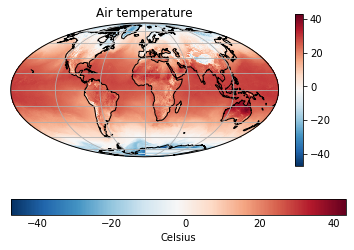

In [67]:
ax = plt.axes(projection=ccrs.Mollweide())
qplt.pcolormesh(t2m[1], cmap='RdBu_r')
plt.colorbar()
ax.coastlines()
ax.gridlines()
plt.show()


In [72]:
for i in range(no_tsteps):
    plt.figure()
    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-20))
    ax.set_extent((-80,20,30,90), crs=ccrs.PlateCarree())
    iplt.pcolormesh(theta[i], cmap='Reds_r', vmin=280, vmax=360)
    ax.coastlines()
    ax.gridlines()
    plt.savefig('pv_' + '{:04}'.format(i) + '.png', dpi=300)
    plt.close()

In [73]:
!convert -delay 40 pv*.png -loop 0 pv.gif

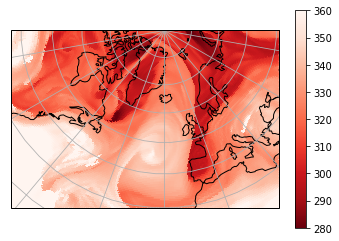

In [137]:
plt.figure()
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-20))
ax.set_extent((-80,20,30,90), crs=ccrs.PlateCarree())
iplt.pcolormesh(theta[0], cmap='Reds_r', vmin=280, vmax=360)
ax.coastlines()
ax.gridlines()
plt.colorbar()
plt.show()
plt.close()

In [75]:
proj = ccrs.NorthPolarStereo(central_longitude=-20)
fig, axes = plt.subplots(3,3, subplot_kw=dict(projection=proj), figsize=(12,8))
for t_step, ax in enumerate(axes.flatten()):
    ax.set_extent((-60,20,30,75), crs=ccrs.PlateCarree())
    iplt.pcolormesh(theta[t_step], axes=ax, cmap='Reds_r', vmin=260, vmax=360)
    iplt.contour(mslp[t_step], p_range, axes=ax, colors='k', linewidths=1)
    ax.gridlines()
    ax.coastlines()
    t_step += 1
plt.savefig('pv.png', dpi=300)
plt.close()

In [76]:
u300=u.extract(iris.Constraint(pressure_level=lambda cell: cell==300))
v300=v.extract(iris.Constraint(pressure_level=lambda cell: cell==300))
h300=height.extract(iris.Constraint(pressure_level=lambda cell: cell==300))

w = VectorWind(u300, v300)

In [77]:
s = w.magnitude()

In [78]:
uchi, vchi, upsi, vpsi = w.helmholtz()

In [79]:
psi = w.streamfunction()
chi = w.velocitypotential()
div = w.divergence()
vort = w.vorticity()
vort_x, vort_y = w.gradient(vort)

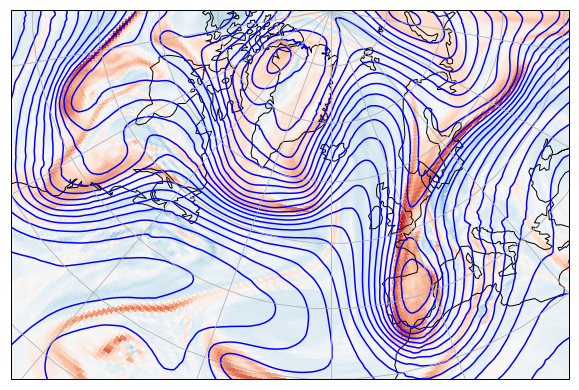

In [80]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-20))
ax.set_extent((-80,20,30,90), crs=ccrs.PlateCarree())
iplt.pcolormesh(vort[4], cmap='RdBu_r', vmin=-0.0005, vmax=0.0005)
iplt.contour(h300[4], range(-1000,10000,60), colors='b')
ax.coastlines()
ax.gridlines()
plt.show()

In [81]:
adv_x = -10**8 * np.dot(vort_x, upsi)
adv_y = -10**8 * np.dot(vort_y, vpsi)
adv=adv_x.copy()

In [82]:
adv.data = adv_x.data + adv_y.data
adv *= 0.5
adv.data=gaussian_filter(adv.data, 2)

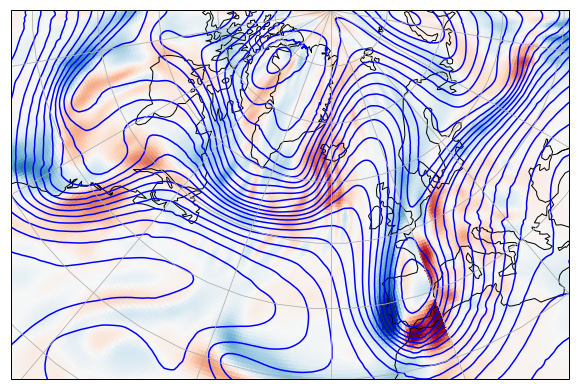

In [83]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-20))
ax.set_extent((-80,20,30,90), crs=ccrs.PlateCarree())
iplt.pcolormesh(adv[4], vmin=-0.5, vmax=0.5, cmap='RdBu_r')
iplt.contour(h300[4], range(-1000,10000,60), colors='b')
ax.coastlines()
ax.gridlines()
plt.show()

Create globe time animation

In [88]:
!rm jet*
for i in range(no_tsteps):
    ax=plt.axes(projection=ccrs.Orthographic(central_latitude=60, central_longitude=-10))
    iplt.pcolormesh(s[i], cmap='BuPu')
    ax.coastlines()
    ax.gridlines()
    plt.savefig('jet_' + '{:04}'.format(i) + '.png', dpi=100)
    #plt.show()
    plt.close()
!convert -delay 20 jet*.png -loop 0 jet.gif

rm: jet*: No such file or directory


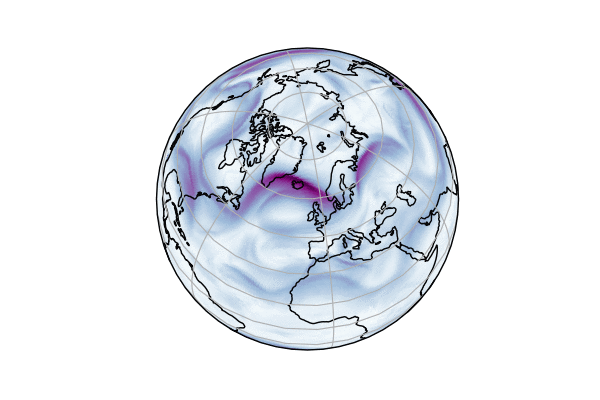

Create globe spinning globe animation

In [ ]:
!rm spin*
for i, l in enumerate(range(-180,180,10)):
    ax=plt.axes(projection=ccrs.Orthographic(central_latitude=60, central_longitude=l))
    iplt.pcolormesh(smax[0], cmap='BuPu')
    ax.coastlines()
    ax.gridlines()
    plt.savefig('spin_' + '{:04}'.format(i) + '.png', dpi=100)
    #plt.show()
    plt.close()
!convert -delay 20 spin*.png -loop 0 spin.gif

In [90]:
hm = height.collapsed('longitude', iris.analysis.MEAN)
ha = height - hm

/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


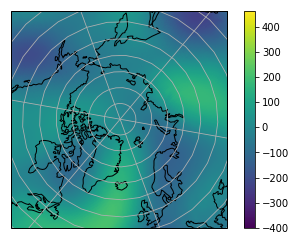

In [91]:
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-20))
ax.set_extent((-180,180,50,90), crs=ccrs.PlateCarree())
iplt.pcolormesh(ha[0][2])
ax.coastlines()
ax.gridlines()
plt.colorbar()
plt.show()
plt.close()

In [92]:
ha1 = ha.extract(iris.Constraint(latitude=lambda cell: 50 < cell < 75)).collapsed('latitude', iris.analysis.MEAN)

/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


/Users/steve/anaconda/envs/grib/lib/python2.7/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'time' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


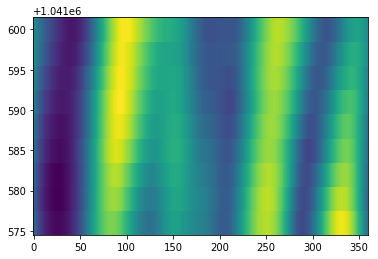

In [93]:
iplt.pcolormesh(ha1[:,0])
plt.show()

In [94]:
pm = mslp.collapsed('longitude', iris.analysis.MEAN)
pma = mslp - pm

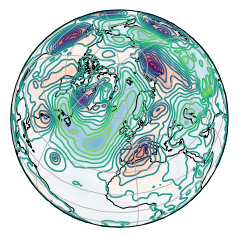

In [95]:
ax=plt.axes(projection=ccrs.Orthographic(central_latitude=60, central_longitude=-10))
iplt.pcolormesh(pma[0], vmin=-50, vmax=50, cmap='RdBu')
iplt.contour(pma[0],18)
ax.coastlines()
ax.gridlines()
#plt.savefig('jet_' + '{:04}'.format(i) + '.png', dpi=100)
plt.show()
plt.close()

In [ ]:
!rm mslp*.png
for i, l in enumerate(range(41)):
    ax=plt.axes(projection=ccrs.Orthographic(central_latitude=60, central_longitude=-10))
    iplt.pcolormesh(pma[i], vmin=-50, vmax=50, cmap='RdBu')
    iplt.contour(mslp[i],16)
    ax.coastlines()
    ax.gridlines()
    plt.savefig('mslp_' + '{:04}'.format(i) + '.png', dpi=100)
    #plt.show()
    plt.close()
!convert -delay 20 mslp*.png -loop 0 mslp.gif

In [96]:
t=temp[0]
h=height[0]

In [97]:
tt=pt[0,:,:,0]
hh=h[:,:,0]
rh0=rh[0,:,:,300]

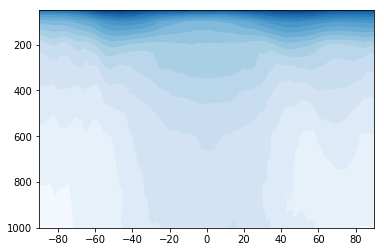

In [98]:
iplt.contourf(tt, 20, cmap='Blues')
plt.gca().invert_yaxis()
plt.show()

In [121]:
pp = iris.coords.AuxCoord((1000./temp.coords()[1].points) ** (287.05 / 1005),
                          long_name='pressure',
                          units='hPa')
print pp
tt = temp.copy()
tt.convert_units('K')
pt=iris.analysis.maths.multiply(tt, pp, 1)
pt.units='K'

AuxCoord(array([2.35289554, 2.13729899, 1.93028702, 1.58358411, 1.48580396,
       1.41041077, 1.34965929, 1.29915323, 1.25617486, 1.21893559,
       1.18620049, 1.15708392, 1.13093082, 1.10724414, 1.0856385 ,
       1.06580958, 1.04751319, 1.03055065, 1.02251729, 1.01475833,
       1.00725753, 1.        ]), standard_name=None, units=Unit('hPa'), long_name='pressure')


In [127]:
ptm = pt.collapsed('longitude', iris.analysis.MEAN)
pta = pt - ptm

In [64]:
#pt.convert_units('Celsius')
pt -= 273.15
d = temp[0,:,60,0].data
p = temp.coords()[1].points
d1 = pt[0,:,60,0].data
p1 = pt.coords()[1].points
dp1 = dp[0,:,60,0].data
dp1.shape
p.shape

(22,)

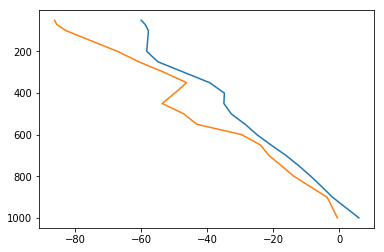

In [65]:
f, ax = plt.subplots()
#plt.plot(d1,p, axes=ax)
plt.plot(d,p, axes=ax)
plt.plot(dp1, p, axes=ax)
ax.invert_yaxis()
plt.show()

TypeError: plot_test_parcel() takes at least 5 arguments (3 given)

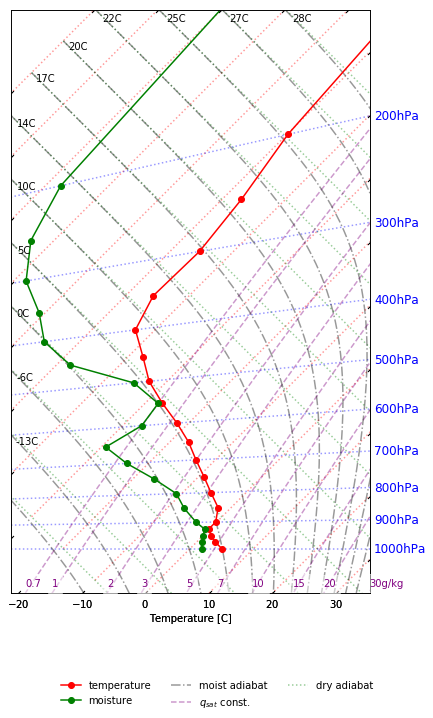

In [102]:
tephigram = Tephigram(x_range=(-40,40))
T = temp[0,:,79,-3].data
T_dp = dp[0,:,79,-3].data
tephigram.plot_sounding(P=p, T=T, T_dp=T_dp)
tephigram.plot_legend()
parcel_info = tephigram.plot_test_parcel( P=P, T=T)

In [60]:
for i in range(temp.data.shape[0]):
    tephigram = Tephigram(x_range=(-40,40))
    T = temp[i,:,79,-3].data
    T_dp = dp[i,:,79,-3].data
    tephigram.plot_sounding(P=p, T=T, T_dp=T_dp)
    tephigram.plot_legend()
    tephigram.savefig('tephi_' + '{:04}'.format(i) + '.png')
    plt.close()
!convert -delay 40 tephi*.png -loop 0 tephi.gif

In [103]:
tephigram.plot_test_parcel?


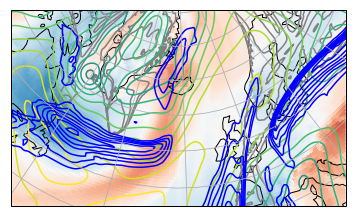

In [162]:
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-20))
ax.set_extent((-60,20,45,75), crs=ccrs.PlateCarree())
iplt.pcolormesh(pta[2][-5], cmap='RdBu_r', vmin=-20, vmax=20)
iplt.contour(theta[2], range(290,310,5), colors='gray')
iplt.contour(mslp[2],p_range)
iplt.contour(s[4], range(40,100, 5), colors='b')
ax.coastlines()
ax.gridlines()
#plt.colorbar()
plt.show()
plt.close()

In [158]:
s[2]

<iris 'Cube' of wind_speed / (m s**-1) (latitude: 361; longitude: 720)>